In [28]:
import pandas as pd
import seaborn as sns
import matplotlib as mpl
import matplotlib.pyplot as plt
import os
import numpy as np
from statsmodels.stats.proportion import proportions_ztest

os.chdir('/project/ssverma_shared/projects/Endometriosis/Endo_Subtyping_Heterogeneity/Feature_Extraction/')

In [5]:
cluster_data = pd.read_csv('cluster_phenotypes_multi_ancestry.csv', index_col='IID')
chart_data = pd.read_csv('Endo_LG_LH_Merged_022224_PMBB.csv', index_col='PMBB_ID')

keep = cluster_data.index.intersection(chart_data.index)
print(len(keep))

cluster_data = cluster_data.loc[keep]
chart_data = chart_data.loc[keep]

20145


/tmp/ipykernel_27290/1023779820.py:2: DtypeWarning: Columns (71,79,83,84,98,99) have mixed types. Specify dtype option on import or set low_memory=False.
  chart_data = pd.read_csv('Endo_LG_LH_Merged_022224_PMBB.csv', index_col='PMBB_ID')


In [9]:
# Endo OR Adeno "True" cases and controls

both_icd = cluster_data['endometriosis']
both_icd_cases = both_icd.index[both_icd == 1]
both_icd_controls = both_icd.index[both_icd == 0]

conf_dx_both = chart_data[['SURG_adeno', 'PROC_adeno', 'PRESUMPTIVE_adeno', 'SURG_endo', 'PROC_endo', 'PRESUMPTIVE_endo']].dropna(how='all').max(axis=1).replace(2, 1)

false_neg0 = chart_data['test_controls_control0'].dropna()
false_neg_both = chart_data['misdiagnosedascontrol_dx'].dropna().str.contains('adeno') | chart_data['misdiagnosedascontrol_dx'].dropna().str.contains('endo')

TP = conf_dx_both.index[conf_dx_both == 1].intersection(both_icd_cases)
FP = conf_dx_both.index[conf_dx_both == 0].intersection(both_icd_cases)

TN = false_neg0.index[false_neg0 == 0].intersection(both_icd_controls)
FN = false_neg_both.index[false_neg_both].intersection(both_icd_controls)

true_both_labels = pd.Series(index=TP.union(FP).union(TN).union(FN))
true_both_labels.loc[TP] = 1
true_both_labels.loc[FN] = 1
true_both_labels.loc[TN] = 0
true_both_labels.loc[FP] = 0

true_both_labels.value_counts()

/tmp/ipykernel_27290/990702283.py:18: FutureWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
  true_both_labels = pd.Series(index=TP.union(FP).union(TN).union(FN))


0.0    719
1.0    679
dtype: int64

In [42]:
cluster_chart_review = chart_data.loc[true_both_labels.index]
cluster_chart_review = cluster_chart_review[cluster_data.loc[cluster_chart_review.index, 'endometriosis'] == 1]
cluster_chart_review['Cluster'] = (cluster_data.loc[cluster_chart_review.index, [c for c in cluster_data.columns if 'cluster_vs' in c]] * np.broadcast_to(np.arange(1, 6), (len(cluster_chart_review), 5))).sum(axis=1)
cluster_chart_review['CONF_adeno'] = cluster_chart_review[['PROC_adeno', 'SURG_adeno']].max(axis=1).fillna(0)
cluster_chart_review['CONF_endo'] = cluster_chart_review[['PROC_endo', 'SURG_endo', 'PRESUMPTIVE_endo']].max(axis=1).fillna(0)
cluster_chart_review['CONF_fibroids'] = cluster_chart_review[['PROC_fibroids', 'SURG_fibroids', 'PRESUMPTIVE_fibroids']].max(axis=1).fillna(0)
cluster_chart_review['Cluster'].value_counts().sort_index()

1.0    121
2.0    161
3.0    191
4.0    124
5.0     83
Name: Cluster, dtype: int64

17.0 46.0 118 513
67.0 287.0 118 517
13.0 49.0 118 513
22.0 74.0 118 514
102.0 454.0 118 528
83.0 353.0 118 519
77.0 309.0 121 559
53.0 239.0 117 540
41.0 130.0 72 284
5.0 21.0 67 279
49.0 265.0 121 559
17.0 49.0 121 559
16.0 84.0 117 539
25.0 183.0 73 320
57.0 213.0 121 559
1.0 2.0 121 559
41.0 169.0 117 539
43.0 114.0 71 284
12.0 92.0 74 342
11.0 60.0 67 283
18.0 118.0 67 279
14.0 49.0 154 477
114.0 240.0 156 479
15.0 47.0 155 476
21.0 75.0 155 477
147.0 409.0 156 490
113.0 323.0 154 483
108.0 278.0 161 519
80.0 212.0 158 499
58.0 113.0 102 254
8.0 18.0 99 247
61.0 253.0 161 519
8.0 58.0 161 519
24.0 76.0 158 498
48.0 160.0 106 287
101.0 169.0 161 519
0.0 3.0 161 519
78.0 132.0 158 498
66.0 91.0 102 253
22.0 82.0 108 308
19.0 52.0 99 251
38.0 98.0 99 247
20.0 43.0 181 450
89.0 265.0 181 454
22.0 40.0 181 450
37.0 59.0 181 451
161.0 395.0 184 462
141.0 295.0 182 455
89.0 297.0 191 489
73.0 219.0 185 472
24.0 147.0 87 269
8.0 18.0 87 259
103.0 211.0 191 489
18.0 48.0 191 489
33.0 67.0 

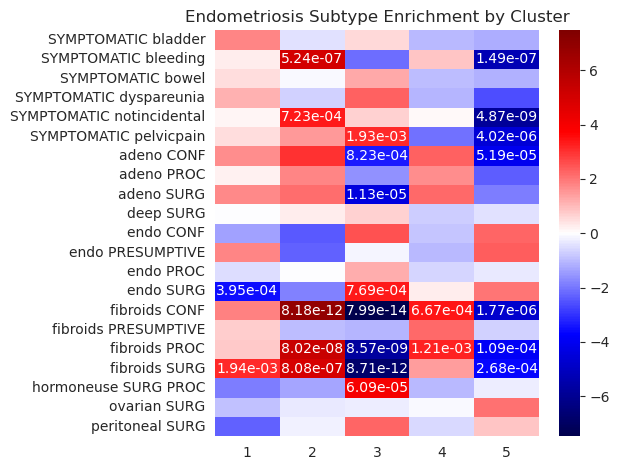

In [44]:
plot_cols = [c for c in cluster_chart_review.columns if 'SURG' in c or 'PROC' in c or 'SYMPTOM' in c or 'PRESUMPTIVE' in c or 'CONF' in c]
plot_cols = [c for c in plot_cols if cluster_chart_review[c].dtype == float]
plot_cols.remove('PRESUMPTIVE_adeno')
plot_phenos = cluster_chart_review[plot_cols]

col_map = {c : c if 'SYMPTOMATIC' in c else '_'.join(reversed(c.split('_'))) for c in plot_cols}
plot_phenos = plot_phenos.rename(columns=col_map)
plot_phenos = plot_phenos.sort_index(axis=1)

clusters = cluster_chart_review['Cluster']

fig, ax = plt.subplots()

cluster_ztests = pd.DataFrame()
cluster_ztests_P = pd.DataFrame()

for cluster in [1, 2, 3, 4, 5]:
    popA = clusters.index[clusters == cluster]
    popB = clusters.index[clusters != cluster]

    for trait in plot_phenos.columns:
        succA = plot_phenos.loc[popA, trait].sum()
        succB = plot_phenos.loc[popB, trait].sum()

        nObsA = plot_phenos.loc[popA, trait].count()
        nObsB = plot_phenos.loc[popB, trait].count()

        print(succA, succB, nObsA, nObsB)

        z, p = proportions_ztest(count=[succA, succB], nobs=[nObsA, nObsB], alternative='two-sided')

        cluster_ztests.loc[trait.replace('_', ' '), cluster] = z
        cluster_ztests_P.loc[trait.replace('_', ' '), cluster] = p

p_cutoff = 0.05 / len(plot_cols)
# p_cutoff = 0.005
# cluster_ztests_P = cluster_ztests_P[cluster_ztests_P.min(axis=1) < p_cutoff]
cluster_ztests_P = cluster_ztests_P.mask(cluster_ztests_P > p_cutoff).applymap(lambda x: '{:.2e}'.format(x)).replace('nan', '')
# cluster_ztests_P = cluster_ztests_P.map(lambda x: '{:.2e}'.format(x)).replace('nan', '')
cluster_ztests = cluster_ztests.loc[cluster_ztests_P.index]

sns.heatmap(cluster_ztests, annot=cluster_ztests_P, fmt='s', cmap='seismic',
            vmin=-cluster_ztests.abs().max().max(),
            vmax=cluster_ztests.abs().max().max(),
            ax=ax, yticklabels=True)

plt.title('Endometriosis Subtype Enrichment by Cluster')
plt.tight_layout()
plt.savefig('Plots/genotyped_PMBB_chart_review_symptoms_subtype_enrichment.png', bbox_inches='tight')
plt.show()